### Дзюба Мария, ВМК, 117 группа

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt


In [2]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv("/content/flights_NY.csv").dropna()

In [4]:
data.head()

,year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance
0,2013,1,1,517.0,2.0,830.0,11.0,UA,N14228,1545,EWR,IAH,227.0,1400
1,2013,1,1,533.0,4.0,850.0,20.0,UA,N24211,1714,LGA,IAH,227.0,1416
2,2013,1,1,542.0,2.0,923.0,33.0,AA,N619AA,1141,JFK,MIA,160.0,1089
3,2013,1,1,544.0,-1.0,1004.0,-18.0,B6,N804JB,725,JFK,BQN,183.0,1576
4,2013,1,1,554.0,-6.0,812.0,-25.0,DL,N668DN,461,LGA,ATL,116.0,762


## №1

In [5]:
def probability(x):
    total_pos_delays = sum(list(x > 0))
    total_delays = len(x)
    return total_pos_delays/total_delays
probs = data.groupby("carrier")["arr_delay"].agg([probability]).reset_index()
probs.head()

,carrier,probability
0,9E,0.383775
1,AA,0.335118
2,AS,0.266573
3,B6,0.436807
4,DL,0.344391


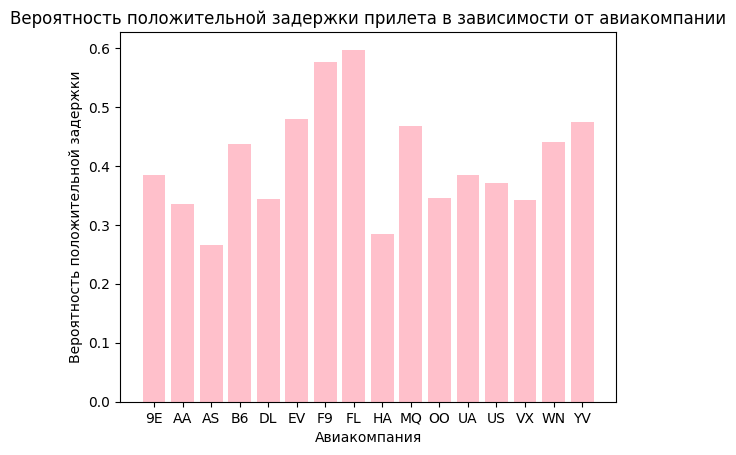

In [6]:
plt.figure()
plt.bar(probs["carrier"], probs["probability"], color = "pink")
plt.xlabel("Авиакомпания")
plt.ylabel("Вероятность положительной задержки")
plt.title("Вероятность положительной задержки прилета в зависимости от авиакомпании")
plt.show()

## №2

В качестве границ для групп возьмем 0.15-й и 0.85-й квантили

Получаем, что "короткие перелеты" - 15% самых коротких; "длинные перелеты" - 15% самых длинных;  "средние перелеты" - все остальные

In [7]:
q15 = data["distance"].quantile(0.15)
q85 = data["distance"].quantile(0.85)

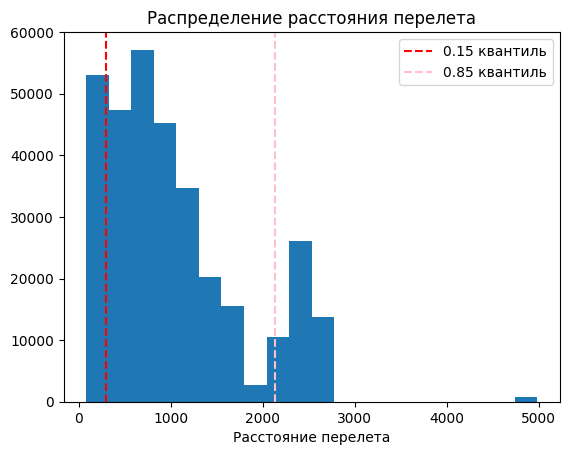

In [8]:
plt.hist(data["distance"], bins=20)
plt.axvline(q15,ls='--', color='red')
plt.axvline(q85,ls='--', color='pink')
plt.legend(["0.15 квантиль", "0.85 квантиль"])
plt.xlabel("Расстояние перелета")
plt.title("Распределение расстояния перелета")
plt.show()

In [9]:
# Аэропорты, куда прилетают длинные перелеты

np.unique(data[data['distance']>q85]['dest'])

array(['ANC', 'BUR', 'HNL', 'LAS', 'LAX', 'LGB', 'OAK', 'PDX', 'PHX',
       'PSP', 'SAN', 'SEA', 'SFO', 'SJC', 'SMF', 'SNA'], dtype=object)

In [10]:
q15 = data["distance"].quantile(0.15)
q85 = data["distance"].quantile(0.85)

answ = []
for dist in data["distance"]:
  if dist < q15:
    answ.append("small_time")
  elif dist > q85:
    answ.append("long_time")
  else:
    answ.append("middle_time")
data["category"] = answ

In [11]:
# среднее время задержки вылета каждой из групп перелетов
df_cat = data.groupby("category")["dep_delay"].agg(['mean']).reset_index()
df_cat

,category,mean
0,long_time,10.782399
1,middle_time,12.842418
2,small_time,12.962132


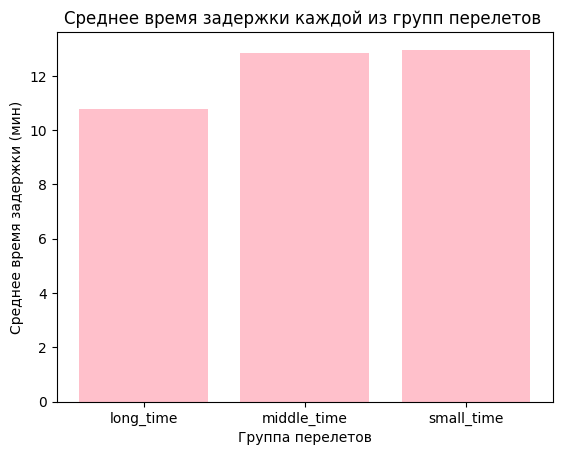

In [12]:
plt.bar(df_cat["category"], df_cat["mean"], color='pink')
plt.title("Среднее время задержки каждой из групп перелетов ")
plt.xlabel("Группа перелетов")
plt.ylabel("Среднее время задержки (мин)")
plt.show()

## 3

Построим доверительные интервалы для средного времени задержки с помощью бутстрепа

In [58]:
from scipy.stats import bootstrap

def get_confidence_interval(x):
    res = bootstrap((x.values,), np.mean, confidence_level=0.95, random_state=1, method='percentile')
    interval = res.confidence_interval
    low, high = interval.low, interval.high
    mean = np.mean(x)
    return mean - low, high - mean, mean

In [59]:
delays_months = data.groupby("month")["dep_delay"]
delays_months= delays_months.agg([get_confidence_interval]).reset_index()

In [60]:
delays_months

,month,get_confidence_interval
0,1,"(0.4395067808167301, 0.44019622698689176, 9.98..."
1,2,"(0.46068993265850544, 0.47229045783744894, 10...."
2,3,"(0.46744677800874435, 0.4760644398251017, 13.1..."
3,4,"(0.49881911188506756, 0.5097808736032512, 13.8..."
4,5,"(0.45417555460750947, 0.44840194823663104, 12...."
5,6,"(0.6078042474607557, 0.6364930747922415, 20.72..."
6,7,"(0.5987929876647939, 0.597114127169263, 21.522..."
7,8,"(0.42888266796494534, 0.4422398803727905, 12.5..."
8,9,"(0.41780081451314377, 0.4272528693076625, 6.63..."
9,10,"(0.33630407435879484, 0.35291949122929545, 6.2..."


In [61]:
delays_months["low"],delays_months["high"] = delays_months["get_confidence_interval"].apply(lambda elem: elem[0]), delays_months["get_confidence_interval"].apply(lambda elem: elem[1])
delays_months["mean"] = delays_months["get_confidence_interval"].apply(lambda elem: elem[2])

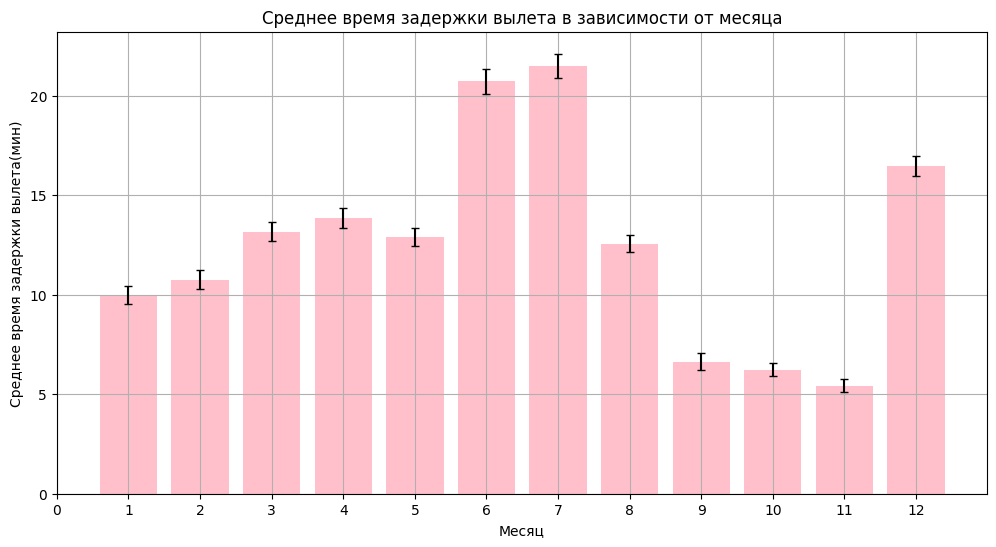

In [62]:
plt.figure(figsize=(12, 6))
delays_ticks = delays_months[["low", "high"]].values
plt.bar(delays_months["month"], delays_months["mean"], yerr=delays_ticks.T, capsize=3 ,color='pink')
plt.xlabel("Месяц")
plt.ylabel("Среднее время задержки вылета(мин)")
plt.title("Среднее время задержки вылета в зависимости от месяца")
plt.grid()
plt.xticks([i for i in range(13)])
plt.show()

Проверим гипотезу о равенстве средних

In [65]:
jan, feb  = data[data["month"] == 1]["arr_delay"], data[data["month"] == 2]["arr_delay"]
pval = stats.ttest_ind(jan, feb, equal_var=(np.var(data[data["month"] == 1]["arr_delay"]) == np.var(data[data["month"] == 2]["arr_delay"]))).pvalue

In [66]:
pval

0.1486106846960724

p-value > 0.05 $\rightarrow$ гипотеза не отвергается на уровне значимости 0.05; на уровне значимости 0.01 гипотеза не отвергается

## 4

Посчитаем коэффициент корреляции Спирмана


In [19]:
from scipy.stats import spearmanr

spearmanr(data["distance"], data["air_time"])[0]

0.9844446623671376

In [20]:
a, b = np.polyfit(data["distance"], data["air_time"], 1)

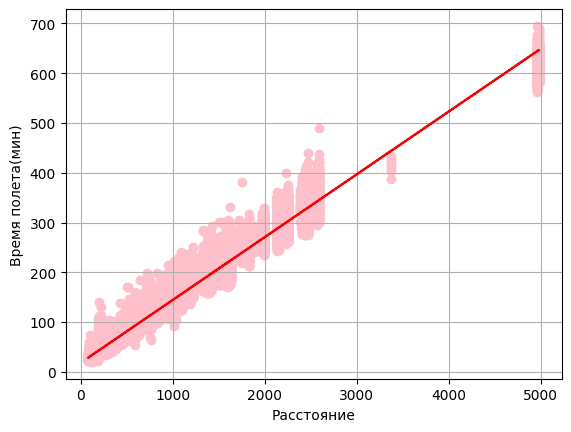

In [21]:
plt.scatter(data["distance"], data["air_time"], color ="pink")
plt.plot(data["distance"], a*data["distance"]+b, c= "red")
plt.ylabel("Время полета(мин)")
plt.grid()
plt.xlabel("Расстояние")
plt.show()

In [23]:
a

0.1261193246738606

Проинтрпретируем коэффициенты: при увеличения расстояние полета на 1 -   в среднем время полета увеличится на 0.126 минуты

## 5

In [24]:
needed_data = data.query('dep_delay >= -15 & dep_delay <= 15')
needed_data

,year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance,category
0,2013,1,1,517.0,2.0,830.0,11.0,UA,N14228,1545,EWR,IAH,227.0,1400,middle_time
1,2013,1,1,533.0,4.0,850.0,20.0,UA,N24211,1714,LGA,IAH,227.0,1416,middle_time
2,2013,1,1,542.0,2.0,923.0,33.0,AA,N619AA,1141,JFK,MIA,160.0,1089,middle_time
3,2013,1,1,544.0,-1.0,1004.0,-18.0,B6,N804JB,725,JFK,BQN,183.0,1576,middle_time
4,2013,1,1,554.0,-6.0,812.0,-25.0,DL,N668DN,461,LGA,ATL,116.0,762,middle_time
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336765,2013,9,30,2240.0,-5.0,2334.0,-17.0,B6,N354JB,1816,JFK,SYR,41.0,209,small_time
336766,2013,9,30,2240.0,-10.0,2347.0,-20.0,B6,N281JB,2002,JFK,BUF,52.0,301,middle_time
336767,2013,9,30,2241.0,-5.0,2345.0,-16.0,B6,N346JB,486,JFK,ROC,47.0,264,small_time
336768,2013,9,30,2307.0,12.0,2359.0,1.0,B6,N565JB,718,JFK,BOS,33.0,187,small_time


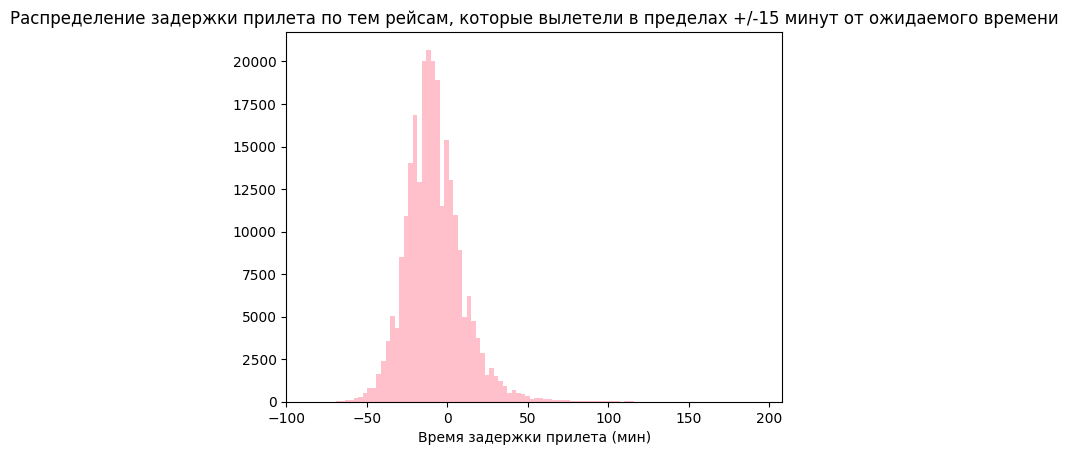

In [27]:
delays = needed_data["arr_delay"]
plt.hist(delays, bins=100, color = 'pink')
plt.xlabel("Время задержки прилета (мин)")
plt.title("Распределение задержки прилета по тем рейсам, которые вылетели в пределах +/-15 минут от ожидаемого времени")
plt.show()

Визуально распределение похоже на нормальное, попробуем оценить его параметры по выборке и изобразить плотность

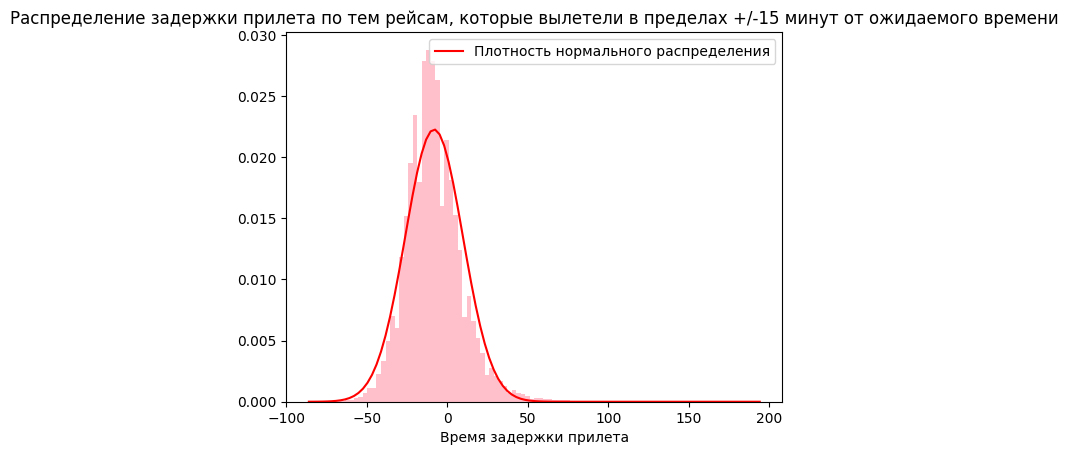

In [28]:
# выделим больше бинов для более гладкого графика плотности нормального распределения
_, bins_for_norm, _ = plt.hist(delays, bins=100, color ='pink', density=True)
m, s = stats.norm.fit(delays)
norm_line = stats.norm.pdf(bins_for_norm, m, s)

plt.plot(bins_for_norm, norm_line, c="red", label="Плотность нормального распределения")
plt.xlabel("Время задержки прилета")
plt.title("Распределение задержки прилета по тем рейсам, которые вылетели в пределах +/-15 минут от ожидаемого времени")
plt.legend()
plt.show()

## 6

In [31]:
data["target"] = (data["arr_delay"] > 15).astype(int)

In [32]:
y = data["target"]
X = data.drop("target", axis=1)

Разобьем выборку на обучающую и валидационную

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
X_train

,year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance,category
17752,2013,1,21,1352.0,-7.0,1526.0,-8.0,UA,N27724,1734,EWR,ORD,130.0,719,middle_time
313100,2013,9,5,1101.0,-4.0,1217.0,2.0,MQ,N505MQ,3230,JFK,DCA,49.0,213,small_time
126586,2013,2,18,1509.0,0.0,1700.0,-8.0,EV,N11194,4166,EWR,GSP,92.0,594,middle_time
201277,2013,5,9,1219.0,-1.0,1402.0,-13.0,EV,N11109,3805,EWR,DTW,77.0,488,middle_time
102571,2013,12,21,2229.0,60.0,102.0,40.0,B6,N645JB,2043,EWR,PBI,138.0,1023,middle_time
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123263,2013,2,14,1727.0,2.0,1830.0,3.0,EV,N13538,4356,EWR,BWI,37.0,169,small_time
266954,2013,7,18,1525.0,5.0,1744.0,-30.0,UA,N58101,1600,EWR,LAX,294.0,2454,long_time
135550,2013,2,28,953.0,-7.0,1134.0,-35.0,US,N769US,1277,LGA,CLT,83.0,544,middle_time
151158,2013,3,17,728.0,-4.0,824.0,-25.0,EV,N14105,4278,EWR,BOS,34.0,200,small_time


In [35]:
one_hot_month = pd.get_dummies(data["month"])
one_hot_category = pd.get_dummies(data["category"])
one_hot_carrier = pd.get_dummies(data["carrier"])



X_train = X_train.join(one_hot_month)
X_train = X_train.join(one_hot_category)
X_train = X_train.join(one_hot_carrier)

X_val = X_val.join(one_hot_month)
X_val = X_val.join(one_hot_category)
X_val = X_val.join(one_hot_carrier)


In [36]:
list(one_hot_carrier.to_dict().keys())

['9E',
 'AA',
 'AS',
 'B6',
 'DL',
 'EV',
 'F9',
 'FL',
 'HA',
 'MQ',
 'OO',
 'UA',
 'US',
 'VX',
 'WN',
 'YV']

In [37]:
X_train.head()

,year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,...,F9,FL,HA,MQ,OO,UA,US,VX,WN,YV
17752,2013,1,21,1352.0,-7.0,1526.0,-8.0,UA,N27724,1734,...,False,False,False,False,False,True,False,False,False,False
313100,2013,9,5,1101.0,-4.0,1217.0,2.0,MQ,N505MQ,3230,...,False,False,False,True,False,False,False,False,False,False
126586,2013,2,18,1509.0,0.0,1700.0,-8.0,EV,N11194,4166,...,False,False,False,False,False,False,False,False,False,False
201277,2013,5,9,1219.0,-1.0,1402.0,-13.0,EV,N11109,3805,...,False,False,False,False,False,False,False,False,False,False
102571,2013,12,21,2229.0,60.0,102.0,40.0,B6,N645JB,2043,...,False,False,False,False,False,False,False,False,False,False


In [38]:
used_columns = ["dep_time",
                "dep_delay",
                "air_time",1,2,3,4,5,6,7,8,9,10,11,12, "long_time", "middle_time", "small_time",'9E',
                'AA',
                'AS',
                'B6',
                'DL',
                'EV',
                'F9',
                'FL',
                'HA',
                'MQ',
                'OO',
                'UA',
                'US',
                'VX',
                'WN',
                'YV']

In [39]:
model = LogisticRegression(random_state=0, max_iter=1000).fit(X_train[used_columns].to_numpy(), y_train.to_numpy().reshape(-1))

In [40]:
y_pred = model.predict_proba(X_val[used_columns].to_numpy())[:, 1]

In [41]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, roc_auc_score, precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_val, y_pred)

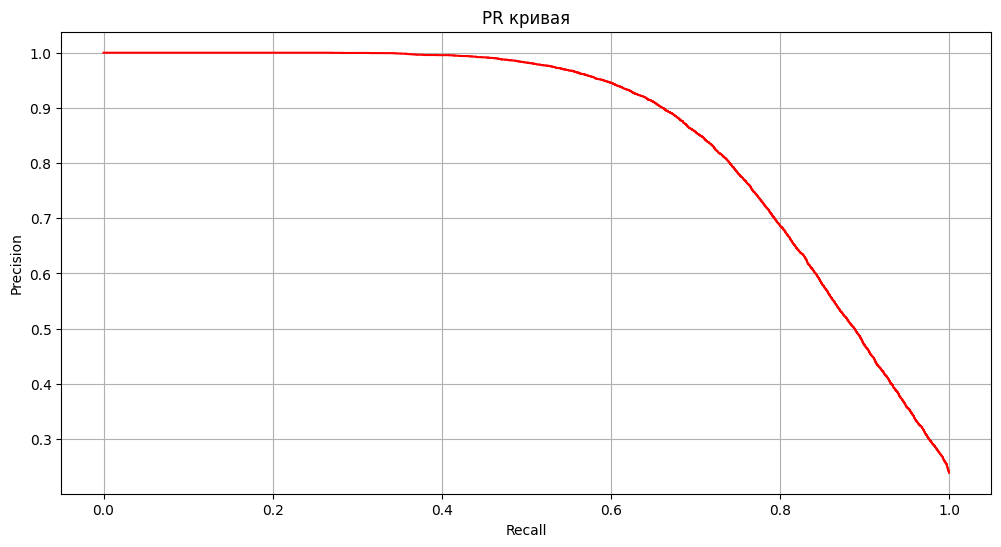

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(recall, precision, c="red")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.title("PR кривая")
plt.show()

In [44]:
roc_auc = roc_auc_score(y_val, y_pred)
print(f"roc-auc: {roc_auc}")

roc-auc: 0.9138154222803686


In [45]:
#Подберем лучший порог для модели на основе F1 метрики F1 = 2*precision*recall/(precision + recall)

def f1(pr, rec):
  return 2*pr*rec/(pr+rec)

max_thresh = 0
max_f1 = 0
for pr, rec, thr in zip(precision, recall, thresholds):
   if f1(pr, rec)>max_f1:
     max_thresh = thr
     max_f1 = f1(pr, rec)

Посмотрим на метркии precision, recall, accuracy при пороге бинаризации 0.5

In [46]:
y_pred = [int(i) for i in model.predict_proba(X_val[used_columns].to_numpy())[:,1]>max_thresh]

In [47]:
sum(y_pred)

13470

In [48]:
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

Precision: 0.8340757238307349
Recall: 0.7187180143295804
Accuracy: 0.8987016954330228
